<img src="img/h++.png" alt="HELIOS++ Logo" width="200" align="right">

# An Introduction to LiDAR Simulation with HELIOS++

**PART I: Airborne laser scanning (ALS)**

LiDAR simulation can be useful for multiple applications:
- Acquisition planning
- Method development and evaluation
- Training data generation (for machine learning)

<img src="img/lidar_sim.png" alt="Visualization of LiDAR Simulation" align="right" width="800">

In this notebook, we will simulate an airborne LiDAR acquisition, mimicing the original acquisition.

In [1]:
# Imports
import os
from pathlib import Path
import time
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact
import pyhelios
from pyhelios import SimulationBuilder
from pyhelios.util import flight_planner
import helper_funcs
import numpy as np
from osgeo import gdal
import rasterio as rio
import laspy

In [2]:
# configure LAStools root
lastools_root = "D:/Software/LAStools"

You can find a comprehensive documentation in the [HELIOS Wiki](https://github.com/3dgeo-heidelberg/helios/wiki).

## 1. The virtual scene

The first component of a simulation is the 3D input scene. HELIOS++ supports loading different file format, including Wavefront OBJ triangle meshes, GeoTIFF rasters or XYZ point clouds, which will be converted to voxel models. In this tutorial, we will use GeoTIFF for loading terrain and XYZ files for loading voxelized vegetation.

**Extracting vegetation points**

Using LAStools "las2txt", we convert the LAZ file of the study size to an ASCII file and extract only vegetation points, which have classification values of 0.

*Note*: With the exclamation mark (`!`), we can issue a shell command and hence run the command line tools of LAStools.

In [3]:
!$lastools_root/bin/las2txt.exe -i data/StA_last.laz -o data/output/StA_last_vegetation.xyz -keep_classification 0 -parse xyz

**Defining scene part files**

We now define the terrain file (GeoTIFF) and the vegetation point cloud (xyz ASCII), as well as a voxel size for voxelizing the vegetation points.

In [4]:
terrain = "data/StA_last_dtm.tiff"
vegetation = "data/output/StA_last_vegetation.xyz"
voxel_size = 0.5

**Writing the scene**

HELIOS++ uses XML files for configuring scanners, platforms, surveys and scenes. Below, we write such an XML file and fill in the values we defined before (`terrain`, `vegetation`, `voxel_size`). Note how each scene part is embedded in a `<part>` tag and uses a different "loader" `filter` depending on the file format.

In [5]:
# Writing the scene XML file
scene_content = f"""<?xml version="1.0" encoding="UTF-8"?>
<document>
    <scene id="helios_scene" name="HELIOS scene">
        
        <part>
            <filter type="geotiffloader">
                <param type="string" key="filepath" value="{terrain}" />
            </filter>
        </part>
        <part>
            <filter type="xyzloader">
                <param type="string" key="filepath" value="{vegetation}" />
                <param type="string" key="separator" value=" " />
                <param type="double" key="voxelSize" value="{voxel_size}" />
            </filter>
        </part>
    </scene>
</document>
"""

In [6]:
# save scene file to the current directory
scene_file = "StA_helios_scene.xml"
with open(scene_file, "w") as f:
    f.write(scene_content)

## 2. Selection of platform and scanner

In this scenario, we will select an airborne platform ("Cirrus SR-22"), similar to the original acquisition. As scanner, we choose the "RIEGL LMS-Q560".

Feel free to try out other scanners in [python/pyhelios/data/scanners_als.xml](https://github.com/3dgeo-heidelberg/helios/blob/main/python/pyhelios/data/scanners_als.xml) but please notice that different scanner types require different survey specifications.

In [8]:
platform = "sr22"
scanner = "riegl_lms-q560"

## 3. Specification of the survey

First, we want to mimic the original acquisition. 

**Waypoints (trajectory)**

For simplification, we will include only two flight passes, which you can define interactively below. A plot will open in a new window, where you can select the waypoints by clicking on the DEM image.

In [9]:
%matplotlib qt
n_pos = 4
dtm, tf, bounds, origin_left, origin_bottom, origin_right, origin_top = helper_funcs.read_raster(terrain)

waypoints = helper_funcs.interactive_flight_trajectory(dtm, tf, n_pos=n_pos)
waypoints = np.array(waypoints)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


You have chosen your flight lines.
[[19864.12, 312362.61], [20400.13, 312819.59], [20584.16, 312602.22], [20093.84, 312183.53]]


Let's plot the chosen configured flight paths on top of the terrain.

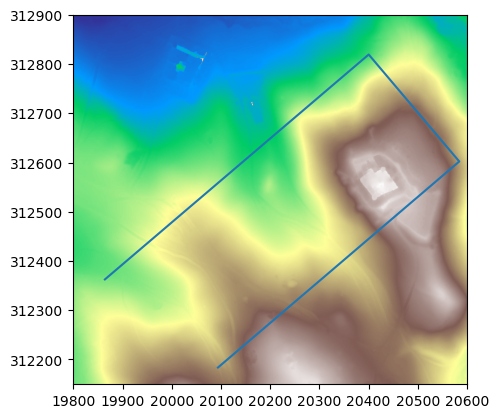

In [10]:
%matplotlib inline
plt.imshow(dtm, cmap="terrain", extent=[origin_left, origin_right, origin_bottom, origin_top])
plt.plot(waypoints[:, 0], waypoints[:, 1])
plt.show()

**Acquisition settings**

Now we configure the acquisition settings.

In [11]:
# compute mean DTM height
dtm_height = np.mean(dtm)

pulse_freq = 100_000
scan_freq = 80
flight_v = 60
alt = dtm_height + 1000  # summing up mean DTM height and desired height above ground level (AGL)
scan_angle = 45

**Writing the survey file**

Finally, we can write the survey file, which is also an XML file. You can find further examples in the [HELIOS++ demo data folder](https://github.com/3dgeo-heidelberg/helios/tree/main/data/surveys).

In [12]:
legs = ""
active = True
for i in range(n_pos):
    if i % 2 == 0:
        active = "true"
    else:
        active = "false"
    
    x, y = waypoints[i]
    
    legs += f'''
    <leg>
            <platformSettings x="{x}" y="{y}" template="platform_als"/>
            <scannerSettings template="scanner_als" active="{active}"/>
    </leg>'''

Note how the survey below links to the `scanner` and `scene` that we defined earlier. 

In [13]:
survey_content = f'''<?xml version="1.0" encoding="UTF-8"?>
<document>
    <platformSettings id="platform_als" movePerSec_m="{flight_v}" z="{alt}" />
    <scannerSettings active="true" id="scanner_als" pulseFreq_hz="{pulse_freq}" scanAngle_deg="{scan_angle}" scanFreq_hz="{scan_freq}" trajectoryTimeInterval_s="0.01"/>
    <survey name="als_survey" platform="data/platforms.xml#{platform}" scanner="data/scanners_als.xml#{scanner}" scene="{scene_file}#helios_scene">
    <FWFSettings beamSampleQuality="3" winSize_ns="1.5"/>
    {legs}
    </survey>
</document>
''' 

In [14]:
survey_file = "als_StA_survey.xml"
with open(survey_file, 'w') as f:
    f.write(survey_content)

## 4. Running the simulation

In [15]:
pyhelios.loggingDefault()
simB = SimulationBuilder(str(survey_file), ['assets/'], 'helios_output/')
simB.setLasOutput(True)
simB.setZipOutput(True)

# build the simulation
sim = simB.build()

# Start the simulation.
start_time = time.time()
sim.start()

if sim.isStarted():
    print(f'Simulation has started!\nSurvey Name: {sim.sim.getSurvey().name}\n{sim.sim.getScanner().toString()}')

while sim.isRunning():
    duration = time.time()-start_time
    mins = duration // 60
    secs = duration % 60
    print('\r'+f'Simulation has been running for {int(mins)} min and {int(secs)} sec. Please wait.', end='')
    time.sleep(1)

if sim.isFinished():
    print('\n'+'Simulation has finished!')

output = sim.join()
meas, traj = pyhelios.outputToNumpy(output)

SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 39.82987499999945 seconds
Simulation has started!
Survey Name: als_survey
Scanner: riegl_lms-q560
Device[0]: riegl_lms-q560
	Average Power: 4 W
	Beam Divergence: 0.5 mrad
	Wavelength: 1064 nm
	Visibility: 23 km

Simulation has been running for 0 min and 6 sec. Please wait.
Simulation has finished!


## 5. Comparison to the real data

Using side views and top views, we visualise the simulated and real-world data to compare them.

In [16]:
# Load the real-world data
las = laspy.read("data/StA_last.laz")
ref = np.array([las.x, las.y, las.z]).T

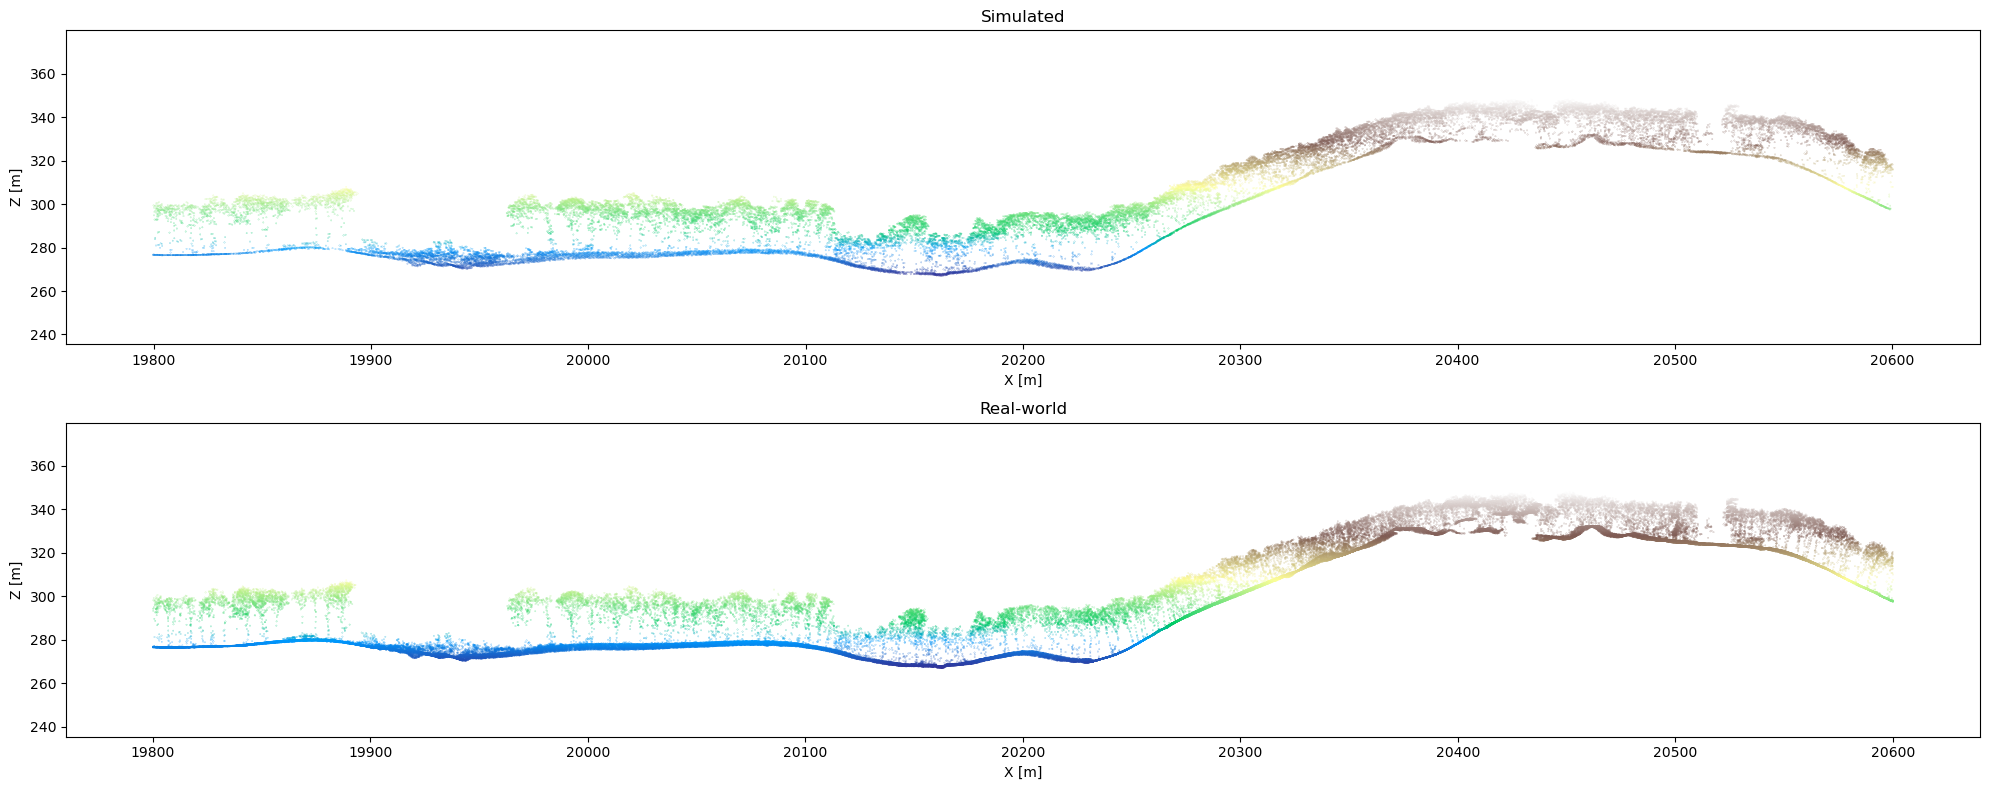

In [17]:
%matplotlib inline
# plotting a cross section
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))

for pc, ax, title in zip([meas, ref], [ax1, ax2], ["Simulated", "Real-world"]):
    idx = (pc[:, 1] > 312580) & (pc[:, 1] < 312590)
    ax.scatter(pc[idx, 0], pc[idx, 2], c=pc[idx, 2], s=0.02, cmap="terrain")
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Z [m]")
    ax.set_title(title)
    ax.axis('equal')

plt.tight_layout()
plt.show()

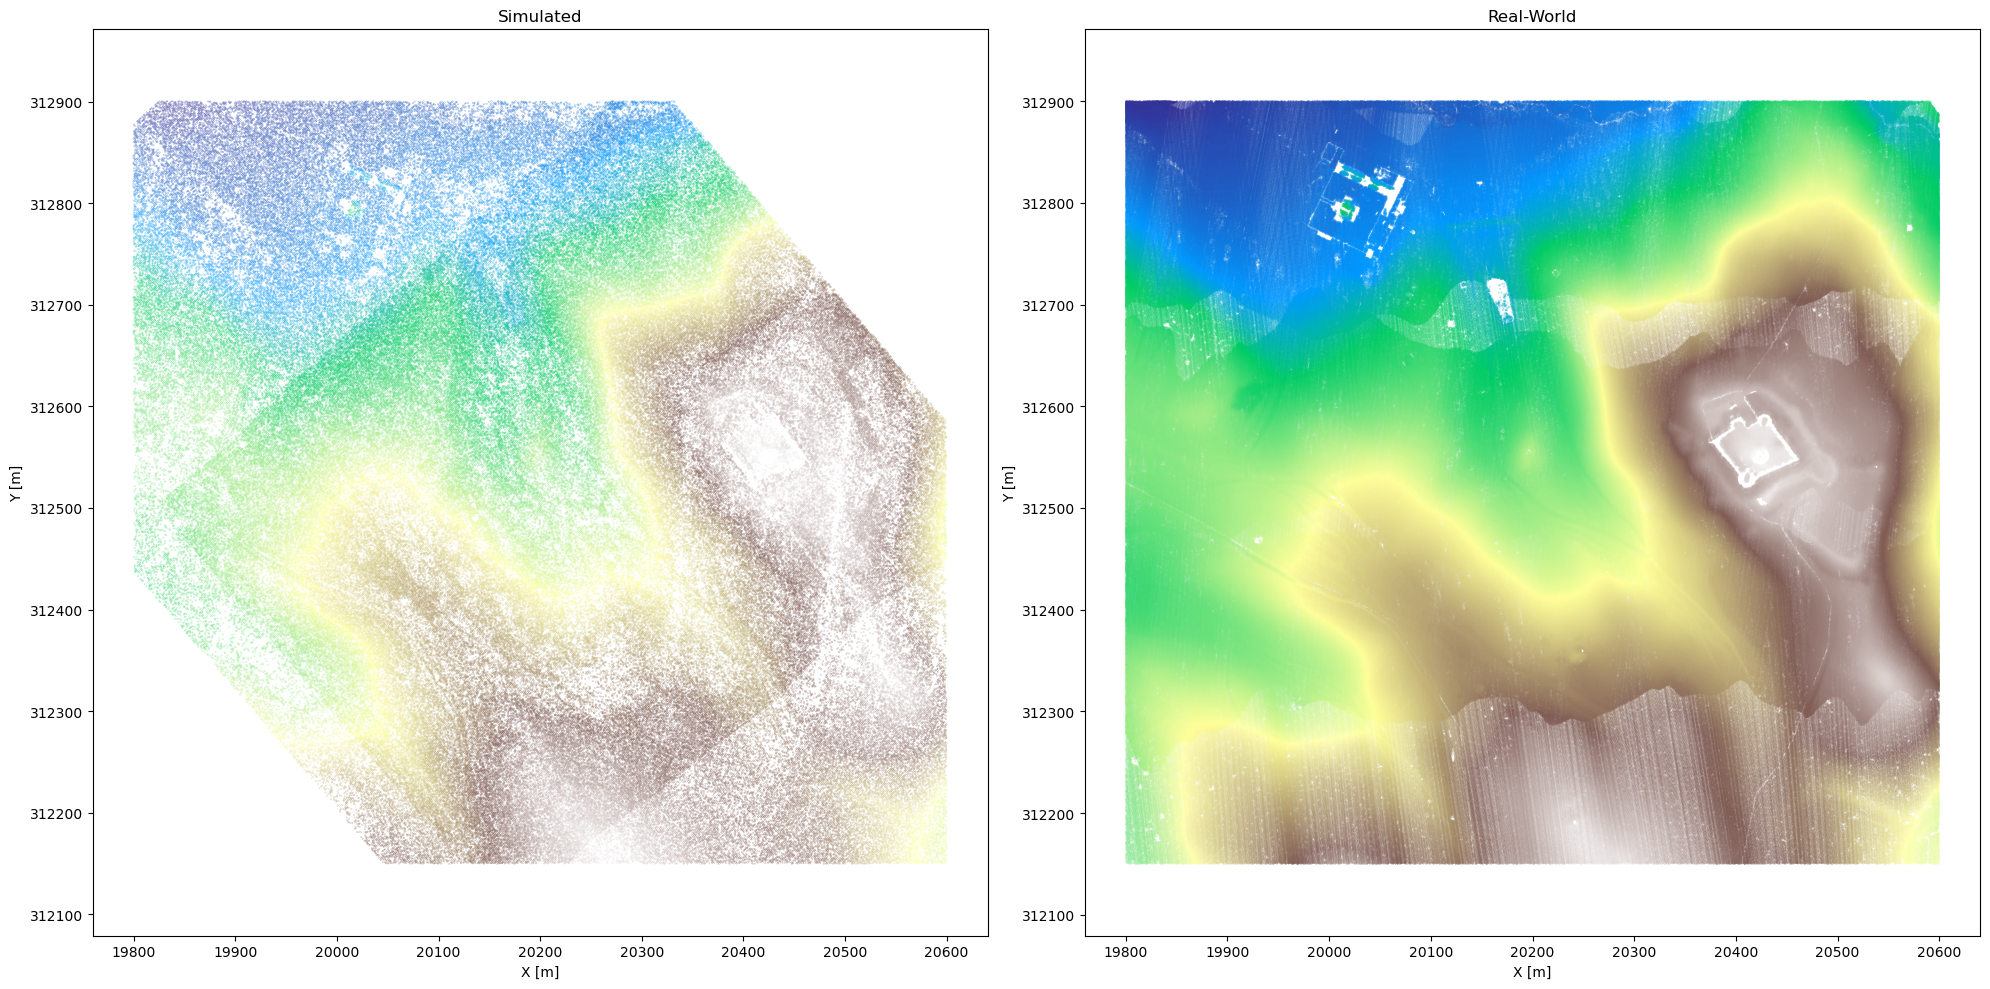

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
meas_ground = meas[meas[:, 14] == 0, :]
ref_ground = ref[las["classification"] == 2, :]

for pc, ax in zip([meas_ground, ref_ground], [ax1, ax2]):
    ax.scatter(pc[::2, 0], pc[::2, 1], c=pc[::2, 2], s=0.02, cmap="terrain")  # only plot every 2nd point so it is faster
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")
    ax.axis('equal')

ax1.set_title("Simulated")
ax2.set_title("Real-World")
plt.tight_layout()
plt.show()

You should see clear differences in point density. You can also see where flight strips overlap and where they don't.